In [1]:
#------------------------------------------------------------------ 
# Script to perform a MC simulation of water clusters on the NVT 
# ensemble. The potential energy is predicted by a GNN previously
# trained. 
#------------------------------------------------------------------ 

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

# Make NumPy printouts easier to read.
np.set_printoptions(precision=4, suppress=True)

from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanAbsoluteErrorde
from tensorflow.keras.optimizers import Adam
from spektral.data import Dataset, DisjointLoader, Graph
from spektral.layers import GlobalSumPool, GATConv
import scipy.sparse as sp
from sklearn.metrics import mean_absolute_error, mean_squared_error
import random
import time
from mendeleev import H, O

2023-06-16 12:49:18.200868: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-16 12:49:18.310066: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-16 12:49:18.732143: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-16 12:49:18.732186: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [3]:
# System 
N = 100             # number of water molecules

# Simulation parameters
#nblocks = 10        # number of blocks for block-averaging
nblocks = 10        # number of blocks for block-averaging
nsteps = 1000       # number of steps per block
#nsteps = 2000       # number of steps per block
temperature = 100   # in Kelvin
#pmove = 0.3         # percentage of particles to be moved in each MC step
#dr_max = 0.004            # length of the movement in atomic units (Bohrs)
#dr_max = 0.2            # length of the movement in atomic units (Bohrs)
dr_max = 0.1            # length of the movement in atomic units (Bohrs)

# Constants
kb = 3.1668114e-6   # Boltzmann constant in atomic units (Hartree/Kelvin)
beta = 1e0 / (kb * temperature)

In [4]:
# Read initial geometry to initialize the GNN model

data_dir = "../dataset_WaterClusters_big/"
file_name = data_dir+"N"+str(N)+"-T100/1000.dat"

class MyDataset(Dataset):

    # Define an auxiliar dataset with one single graph

    def __init__(self, r2_cutoff, **kwargs):

        self.r2_cutoff = r2_cutoff
        self.geometry_path = file_name
        super().__init__(**kwargs)

    # Define data matrices of a graph (x,a,e)

    def read(self):
            
        def make_graph():

            # Process the header of the geometry file
            geom_path = self.geometry_path
            gfile = open(geom_path,'r')
            line = gfile.readline()
            n_molecules = int(gfile.readline())
            line = gfile.readline()
            line = gfile.readline()
            line = gfile.readline()
            columns = line.split()
            energy = float(columns[0])
            #energy = float(columns[1]) # electron contribution
            line = gfile.readline()
            line = gfile.readline()            

            # Node features (atom type and position [x,y,z])            
            n_nodes = 3*n_molecules
            num_physical_features = 4
            num_abstract_features = 0
            num_node_features = num_physical_features + num_abstract_features
            x = np.zeros((n_nodes, num_node_features))
            pos = np.zeros((n_nodes, 3))
            for inode in range(n_nodes):
                line = gfile.readline()
                columns = line.split()
                if (inode%3==0):
                    x[inode,0] = O.atomic_number
                else:
                    x[inode,0] = H.atomic_number
                pos[inode,0:] = columns[1:]
                x[inode,1:] = pos[inode,0:]
            gfile.close()                

            # Binary Adjacency matrix (two nodes/atoms are connected if rij2 < r2_cutoff)
            a = np.zeros((n_nodes,n_nodes))
            n_edges = 0
            for iatom in range(3*n_molecules):
                for jatom in range(iatom+1,3*n_molecules):
                    rij = pos[iatom,0:] - pos[jatom,0:]
                    r2 = np.dot(rij,rij)
                    if (r2 <= self.r2_cutoff):
                        a[iatom,jatom] = 1
                        n_edges = n_edges + 1            
            a = np.maximum(a, a.T)#.astype(int) # Adjacency matrix is symetric in this case
            a = sp.csr_matrix(a)
            #a = normalized_adjacency(a, symmetric=True)
            
            # No edge features in this case
                
            # Labels
            num_labels = 1
            self.num_labels = num_labels
            y = np.zeros(num_labels,)
            y[0,] = energy

            print(str(geom_path)+"    Energy "+str(y[0,]))

            return Graph(x=x, a=a, y=y)

        # We must return a list of Graph objects
        return [make_graph()]        

d_cutoff = 6.0
d2_cutoff = d_cutoff * d_cutoff
dataset0 = MyDataset( d2_cutoff ) # dataset with initial graph
dataset_aux = MyDataset( d2_cutoff ) # auxiliar dataset

../dataset_WaterClusters_big/N100-T100/1000.dat    Energy -1.60519135
../dataset_WaterClusters_big/N100-T100/1000.dat    Energy -1.60519135


In [5]:
# Initialize the GNN model

# Config 
learning_rate = 1e-3  # Learning rate
epochs = 1  # Number of training epochs
batch_size = 1  # Batch size
n_out = 1
loader_tr = DisjointLoader(dataset0, batch_size=batch_size, epochs=epochs)

# Build the model
class Net(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = GATConv(8,attn_heads=7,dropout_rate=0,activation="relu")
        self.conv2 = GATConv(8,attn_heads=7,dropout_rate=0,activation="relu")
        self.global_pool = GlobalSumPool()
        self.dense1 = Dense(128,activation="relu")
        self.dense2 = Dense(128,activation="relu")
        self.dense = Dense(n_out)

    def call(self, inputs):
        #x, a, e, i = inputs
        x, a, i = inputs
        x = self.conv1([x, a])
        x = self.conv2([x, a])
        output = self.global_pool([x, i])
        output = self.dense1(output)
        output = self.dense2(output)
        output = self.dense(output)

        return output

model = Net()
optimizer = Adam(learning_rate)
loss_fn = MeanAbsoluteError()

@tf.function(input_signature=loader_tr.tf_signature(), experimental_relax_shapes=True)
def train_step(inputs, target):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(target, predictions) + sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# fit the model one epoch
nepoch = 1
step = loss = 0
loss_train = []
for batch in loader_tr:
    step += 1
    loss += train_step(*batch)
    if step == loader_tr.steps_per_epoch:
        step = 0
        print(str(nepoch)+" Loss: {}".format(loss / loader_tr.steps_per_epoch))
        loss_train.append(loss / loader_tr.steps_per_epoch)

        nepoch = nepoch + 1
        
        loss = 0

# Load pre-trained weights

# load model weights
model.load_weights('../Models/GATConv_electron_weights.hdf5')

# Show the model architecture
model.summary()

2023-06-16 12:49:34.125612: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-16 12:49:34.153432: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-06-16 12:49:34.153455: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-06-16 12:49:34.153928: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neur

1 Loss: 3.3245363235473633
Model: "net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gat_conv (GATConv)          multiple                  392       
                                                                 
 gat_conv_1 (GATConv)        multiple                  3304      
                                                                 
 global_sum_pool (GlobalSumP  multiple                 0         
 ool)                                                            
                                                                 
 dense (Dense)               multiple                  7296      
                                                                 
 dense_1 (Dense)             multiple                  16512     
                                                                 
 dense_2 (Dense)             multiple                  129       
                                    

In [6]:
# Function to evaluate the energy of a new molecular geometry

def energy_GNN(inputs):

    # Inputs are data matrices of the graph
    x, a, e = inputs

    # We save the new graph into the auxiliar dataset and define
    # a disjoint loader to evaluate model
    graph_aux = Graph(x=x,a=a,e=e,y=0)
    dataset_aux[0] = graph_aux
    loader_aux = DisjointLoader(dataset_aux, epochs=1) 
    for batch in loader_aux:
        input, y = batch
        energy_predicted = model(input, training=False)

    return float(energy_predicted)

# Check the implementation
graph0 = dataset0[0]
x0 = graph0.x
a0 = graph0.a
e0 = graph0.e
y0 = graph0.y
inputs = [x0, a0, e0]
print( "Predicted: "+str(energy_GNN(inputs)) )


Predicted: -0.11278238892555237


In [7]:
print(x0.shape)
print(a0.shape)
print(e0)
print(y0)

(300, 4)
(300, 300)
None
[-1.6052]


In [8]:
# Function to compute adjacency matrix from the atomic positions

def adjacency(position):

    nat,ndim = position.shape
    nat = int(nat)
    nmol = int(nat/3)
    
    a = np.zeros((nat,nat))

    for iatom in range(3*nmol):
        for jatom in range(iatom+1,3*nmol):
            rij = position[iatom,:] - position[jatom,:]
            r2 = np.dot(rij,rij)
            if (r2 <= d2_cutoff):
                a[iatom,jatom] = 1
    a = np.maximum(a, a.T)#.astype(int) # Adjacency matrix is symetric in this case
    a = sp.csr_matrix(a)
    
    return a

In [9]:
# Read single geometry and predict its electronic energy

data_dir = "../dataset_WaterClusters_big/"
file_name = data_dir+"N"+str(N)+"-T100/2000.dat"

gfile = open(file_name,'r')
line = gfile.readline()
line = gfile.readline()
columns = line.split()
nmols = int(columns[0])
natoms = 3*nmols
pos = np.zeros((natoms,3))
line = gfile.readline()
line = gfile.readline()
line = gfile.readline()
line = gfile.readline()
line = gfile.readline()

for i in range(natoms):
    line = gfile.readline()
    #print(line)
    columns = line.split()
    pos[i,0] = float(columns[1])
    pos[i,1] = float(columns[2])
    pos[i,2] = float(columns[3])
gfile.close()

# Convert from ang to a.u. 
#ang_to_au = 1e0 / 0.529177e0
#pos = pos * ang_to_au
#print(pos0[0,:])

# Define node atributes and adjacency matrix

x = np.zeros((natoms,4))
a = np.zeros((natoms,natoms))
e = e0
y = y0
""" for i in range(natoms):
    if (i%3==0):
        x[i,0] = 8.0 # oxygen
    else:
        x[i,0] = 1.0 # hydrogen
    x[i,1:] = pos[i,:] """
x[:,0] = 1.0 # hydrogens
for i in range(nmols):
    x[int(3*i),0] = 8.0 # oxygens
x[:,1:] = pos[:,:]

a = adjacency(pos)
inputs = [x, a, e]
print( "Predicted: "+str(energy_GNN(inputs)) )

Predicted: -0.11280027031898499


In [10]:
# Function to decide if a random movement is accepted with Metropolist test

exponent_guard = 75.0

def metropolis(delta):

    # Input: delta is the negative of argument of exponential

    """ if(delta>exponent_guard): # Too high, reject without evaluation
        accept = False
    elif(delta<0): # downhill, accept without evaluating
        accept = True"""
    if(delta<0): # downhill, accept without evaluating
        accept = True
    else: # Metropolis test
        zeta = random.uniform(0,1) # uniform random number in (0,1)
        accept = np.exp(-delta) > zeta

    return accept

In [11]:
# function to translate the center of masses to the origin

m_hy = 1e0    # mass of hydrogen atom
m_ox = 16e0   # mass of oxygen atom
m_water = 2*m_hy + m_ox # mass of water molecule

#nmols_max = 500
nmols_max = N
natoms_max = nmols_max*3
m_at = np.zeros(natoms_max)  # auxiliar vector storing masses of H and O atoms
for iat in range(natoms_max):
    if(iat%3==0):
        m_at[iat] = m_ox
    else:
        m_at[iat] = m_hy

def trans_cm( rpos ):

    # compute center of masses
    r_cm = np.zeros(3)
    m_total = 0e0
    n_atoms = rpos.shape[0]
    rpos_trans = np.zeros((n_atoms,3))
    n_mols = n_atoms/3
    #m_at = m_at[0:n_atoms]
    #for iat in range(n_atoms):
    #    r_cm[:] = r_cm[:] + m_at[iat]*rpos[iat,:]
    r_cm = np.dot(m_at,rpos)
    m_total = n_mols * m_water
    r_cm = r_cm / m_total

    #print(r_cm)
    #print(np.dot(m_at,rpos)/( m_water * n_mols ))

    # translate center of masses
    #for iat in range(n_atoms):
    #    rpos_trans[iat,:] = rpos[iat,:] - r_cm[:]
    rpos_trans = rpos - r_cm

    return rpos_trans

# Test   
#rtest = trans_cm(pos)
#rtest2 = trans_cm(rtest)

In [12]:
# Read equilibrated geometry at the selected cluster size and temperature

data_dir = "../dataset_WaterClusters_big/"
file_name = data_dir+"N"+str(N)+"-T100/2000.dat"

gfile = open(file_name,'r')
line = gfile.readline()
line = gfile.readline()
columns = line.split()
nmols = int(columns[0])
natoms = 3*nmols
pos_ini = np.zeros((natoms,3))
line = gfile.readline()
line = gfile.readline()
line = gfile.readline()
line = gfile.readline()
line = gfile.readline()

for i in range(natoms):
    line = gfile.readline()
    #print(line)
    columns = line.split()
    pos_ini[i,0] = float(columns[1])
    pos_ini[i,1] = float(columns[2])
    pos_ini[i,2] = float(columns[3])
gfile.close()

# Convert from ang to a.u. 
#ang_to_au = 1e0 / 0.529177e0
#pos = pos * ang_to_au
#print(pos0[0,:])

# Define node atributes and adjacency matrix

x_ini = np.zeros((natoms,4))
a_ini = np.zeros((natoms,natoms))
e_ini = e0
y_ini = y0
x_ini[:,0] = 1.0 # hydrogens
for i in range(nmols):
    x_ini[int(3*i),0] = 8.0 # oxygens
x_ini[:,1:] = pos_ini[:,:]
a_ini = adjacency(pos_ini)
inputs = [x_ini, a_ini, e_ini]
print( "Predicted: "+str(energy_GNN(inputs)) )

# save positions into graph_ini
graph_ini = Graph(x=x_ini,a=a_ini,e=e_ini,y=0)

Predicted: -0.11280027031898499


In [13]:
# function implementing SPC/F potential

kelvin_to_au = 3.16683e-6
mdyn_to_au = 1e0 / 8.2388584e0
mdyntimesang_to_au = 1e0 / 4.3598149e0
mdynoverang_to_au = 1e0 / 15.5691905e0
kcalmol_to_au = 1e0 / 627.51e0
ang_to_au = 1e0 / 0.529177e0
deg_to_rad = np.pi / 180.0e0
eV = 1e0 / 13.60580e0 / 2e0
Kelvin = eV / 11604.45e0

# potential parameters
      
epsilon = 78.22e0       # kelvins
sigma = 3.165e0         # Angstrom
qh = 0.41e0             # electron charge
qo = -2e0 * qh          # electron charge

# SPC/F
rhow = 2.566e0          # Angstroms^-1. Bug in J. Chem. Phys., Vol 106, No. 6, 1997 !!!
dw = 0.708e0            # mdyn * Angstrom
roh_eq = 1.0e0          # Angstroms
theta_eq = 109.47e0     # º
bc = 2.283e0            # mdyn / Angstrom
cc = -1.469e0           # mdyn / Angstrom
dc = 0.776e0            # mdyn / Angstrom

# convert parameters to atomic units

epsilon = epsilon * Kelvin
sigma = sigma * ang_to_au
rhow = rhow / ang_to_au
dw = dw * mdyntimesang_to_au
roh_eq = roh_eq * ang_to_au
theta_eq = theta_eq * deg_to_rad
bc = bc * mdynoverang_to_au
cc = cc * mdynoverang_to_au
dc = dc * mdynoverang_to_au

alj = 4e0 * epsilon * sigma ** 12e0
blj = 4e0 * epsilon * sigma ** 6e0
rhh_eq = 2e0 * roh_eq * np.sin( theta_eq / 2e0 )
kw = dw*rhow*rhow
kb = bc/2e0
kc = cc
kd = dc

def SPCF( rpos ):

      ustretch = 0e0
      ubend = 0e0
      ulj = 0e0
      ucoulomb = 0e0

      n_atoms = rpos.shape[0]
      n_mols = int(n_atoms/3)

      for imol in range(n_mols):

            iox = 3*imol
            ih1 = iox+1
            ih2 = iox+2

            # intra-molecular energy

            roh1 = rpos[ih1,:] - rpos[iox,:]
            roh2 = rpos[ih2,:] - rpos[iox,:]
            rhh = rpos[ih2,:] - rpos[ih1,:]

            roh1 = np.sqrt(np.dot(roh1,roh1))
            roh2 = np.sqrt(np.dot(roh2,roh2))
            rhh = np.sqrt(np.dot(rhh,rhh))

            # O-H streching

            deq = roh1 - roh_eq
            deq2 = deq*deq
            vw1 = kw * deq2
            deq = roh2 - roh_eq
            deq2 = deq*deq
            vw2 = kw * deq2

            ustretch = ustretch + vw1 + vw2

            # H-O-H bending is composed by three terms: Vb, Vc and Vd terms

            # Vb term: H-H stretching
            deq = rhh - rhh_eq
            deq2 = deq*deq
            vb = kb * deq2

            ustretch = ustretch + vb

            # Vc term

            vc = kc * ( roh1 + roh2 - 2e0*roh_eq ) * ( rhh - rhh_eq )
            dvc_droh = kc * ( rhh - rhh_eq )
            dvc_drhh = kc * ( roh1 + roh2 - 2e0*roh_eq )
         
            ubend = ubend + vc

            # Vd term

            vd = kd * ( roh1 - roh_eq ) * ( roh2 - roh_eq )
            dvd_droh1 = kd * ( roh2 - roh_eq )
            dvd_droh2 = kd * ( roh1 - roh_eq )         
         
            ubend = ubend + vd

            # inter-molecular energy
            for jmol in range(imol+1,n_mols):

                  jox = 3*jmol
                  rij = rpos[jox,:] - rpos[iox,:]

                  rij = np.sqrt(np.dot(rij,rij))
                  rij6 = rij**6e0
                  rij12 = rij**12e0

                  # O-O Lennard-Jones interaction

                  ulj = ulj + ( alj/rij6 - blj ) / rij6

                  # Coulomb interaction between charges k and l of imol and jmol

                  for k in range(3):

                        ik = k+ 3*imol
                        rk = rpos[ik,:]

                        if(k==0):
                              qk = qo
                        else:
                              qk = qh

                        for l in range(3):
                              il = l + 3*jmol
                              rl = rpos[il,:]

                              if(l==0):
                                    ql = qo
                              else:
                                    ql = qh

                              rkl = rl - rk
                              rkl = np.sqrt(np.dot(rkl,rkl))

                              ucoulomb = ucoulomb + qk * ql / rkl

      uinter = ulj + ucoulomb
      uintra = ustretch + ubend
      V_SPCF = uinter + uintra

      return V_SPCF

print(SPCF(pos_ini))


-1.6112604554705725


In [14]:
# MC simulation

natoms, nfeatures = x_ini.shape

# averages per block
potential_block = np.zeros(nblocks)
potential_block_el = np.zeros(nblocks)

# Initial energy
x_old = graph_ini.x
a_old = graph_ini.a
e_old = e0
y_old = y0
inputs = [x_old, a_old, e_old]
r_old = x_old[:,1:4]
Energy_SPCF = SPCF(r_old)
Energy_GNN = energy_GNN(inputs)
potential_old =  Energy_SPCF #+ Energy_GNN
potential_old_el = Energy_GNN

print('Initial Energy: '+str(potential_old))

# Inizialization of variables
n = 0
nmoves = 0
potential_accu = 0
potential_accu_el = 0
start_time = time.time()
energy_list = []
energy_list_el = []

# MC loop
for iblock in range(nblocks):

    nmoves_iblock = 0
    potential_iblock = 0
    potential_iblock_el = 0

    for istep in range(nsteps):

        n=n+1
        #if(istep%10==0): print(istep)
        #print(istep)

        # single-atom move
        atom_selected = random.randint(0,natoms-1)   # select number between 0 and natoms-1 (both included)
        ux = random.uniform(0,1)
        uy = random.uniform(0,1)
        uz = random.uniform(0,1)
        r_new = r_old.copy()          
        r_new[atom_selected,0] = r_old[atom_selected,0] + (ux-0.5)*dr_max
        r_new[atom_selected,1] = r_old[atom_selected,1] + (uy-0.5)*dr_max
        r_new[atom_selected,2] = r_old[atom_selected,2] + (uz-0.5)*dr_max
        r_new = trans_cm(r_new)      
        x_new = x_old.copy() 
        x_new[atom_selected,1:] = r_new[atom_selected,:]
        a_new = adjacency(r_new)
        inputs = [x_new, a_new, e0]
        Energy_SPCF = SPCF(r_new)
        Energy_GNN = energy_GNN(inputs) 
        potential_new = Energy_SPCF #+ Energy_GNN
        potential_new_el = Energy_GNN
        #print(str(atom_selected)+"  "+str(potential_old)+"  "+str(potential_new))

        # Accept of reject the movement
        delta = (potential_new - potential_old) * beta
        if( metropolis(delta) ):
            potential_old = potential_new
            potential_markov = potential_new
            potential_old_el = potential_new_el
            potential_markov_el = potential_new_el
            r_old = r_new.copy()
            #r_old = trans_cm(r_old)
            x_old = x_new.copy() 
            nmoves = nmoves + 1    
            nmoves_iblock = nmoves_iblock + 1    
        else:
            potential_markov = potential_old                
            potential_markov_el = potential_old_el

        # accumulate properties with new element of the Markov chain
        potential_accu = potential_accu + potential_markov
        potential_iblock = potential_iblock + potential_markov
        if((istep+1)%5==0): energy_list.append(potential_markov)
        potential_accu_el = potential_accu_el + potential_markov_el
        potential_iblock_el = potential_iblock_el + potential_markov_el
        if((istep+1)%5==0): energy_list_el.append(potential_markov_el)

    # accumulate block averages
    #potential_block[iblock] = potential_iblock / nmoves_iblock
    potential_block[iblock] = potential_iblock /nsteps
    potential_block_el[iblock] = potential_iblock_el /nsteps
    print("block "+str(iblock)+": Energy "+str(np.round(potential_block[iblock],4))+", acceptance "+str(np.round(nmoves_iblock/nsteps*100,2))+" %"+", El Energy "+str(np.round(potential_block_el[iblock],4)))        
 
end_time = time.time()   
exe_time = end_time-start_time # in seconds

metro_ratio = float(nmoves)/float(n)*100    # should be around 50%
#potential_avrg = potential_accu / float(nmoves)
potential_avrg = potential_accu / float(nsteps*nblocks)
print("Acceptance ratio: "+str(metro_ratio))
print("Potential average: "+str(potential_avrg))
print("Exe time (seconds): "+str(exe_time))

print()
potential_avrg_el = potential_accu_el / float(nsteps*nblocks)
print("Electronic Potential average: "+str(potential_avrg_el))

Initial Energy: -1.6112604554705725
block 0: Energy -1.6147, acceptance 55.2 %, El Energy -0.1124
block 1: Energy -1.618, acceptance 54.7 %, El Energy -0.1098
block 2: Energy -1.6228, acceptance 52.5 %, El Energy -0.11
block 3: Energy -1.6299, acceptance 52.6 %, El Energy -0.1107
block 4: Energy -1.6336, acceptance 52.5 %, El Energy -0.1113
block 5: Energy -1.6352, acceptance 53.2 %, El Energy -0.1116
block 6: Energy -1.6409, acceptance 54.5 %, El Energy -0.1117
block 7: Energy -1.642, acceptance 51.3 %, El Energy -0.1115
block 8: Energy -1.6424, acceptance 51.5 %, El Energy -0.1121
block 9: Energy -1.6439, acceptance 53.6 %, El Energy -0.1122
Acceptance ratio: 53.16
Potential average: -1.6323534102311936
Exe time (seconds): 1800.322457075119

Electronic Potential average: -0.11132216591536999


In [107]:
# Update graph_ini to restart the MC simulaiton
#graph_ini = Graph(x=x_new,a=a_new,e=e0,y=0)

<function TextIOWrapper.close()>

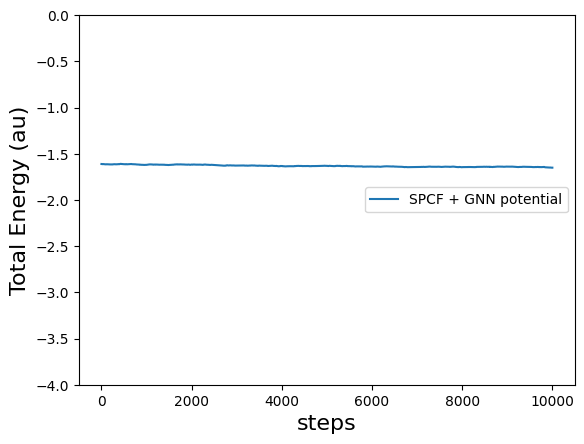

In [16]:
# Plot Energy vs time

#steps = np.arange(len(energy_list))
steps = np.linspace(0,10000,2000)
energy_list_total = energy_list.copy()
energy_list_total[:] = energy_list[:] + energy_list_el[:]
plt.plot(steps, energy_list, label='SPCF + GNN potential') # AÑADIDO
#plt.plot(steps, energy_list_total, label='SPCF + GNN potential') # AÑADIDO
plt.ylim([-4,0])
plt.xlabel("steps", fontsize=16)
plt.legend(loc='center right')
plt.ylabel("Total Energy (au)", fontsize=16)

# Write energies into an output file
output_file = './E-N'+str(N)+'-T'+str(temperature)+'.dat'
ofile = open(output_file,'w')
for i in range(len(energy_list[0:4000])):
    line = str(5*(i+1))+'   '+str(energy_list[i])+'   '+str(energy_list_el[i])
    ofile.write(line+'\n')
ofile.close


In [17]:
# Compute uncertainty with block-averaging
print(potential_block)
""" sigma = 0
for iblock in range(nblocks):
    sigma = sigma + (potential_block[iblock]-potential_avrg)**2
sigma = sigma / (nblocks-1)
sigma = np.sqrt(sigma)
print(sigma)"""
sigma = np.std(potential_block)

print() 
print("Avrg potential (a.u.): "+str(potential_avrg))
print("Sigma: "+str(sigma))
print()
au_to_kcalmol = 627.52
print("Avrg potential/N (kcal/mol): "+str(potential_avrg*au_to_kcalmol/N))
print("Sigma: "+str(sigma*au_to_kcalmol/N))

    

[-1.6147 -1.618  -1.6228 -1.6299 -1.6336 -1.6352 -1.6409 -1.642  -1.6424
 -1.6439]

Avrg potential (a.u.): -1.6323534102311936
Sigma: 0.010111435288621568

Avrg potential/N (kcal/mol): -10.243344119882785
Sigma: 0.06345127872315806


In [18]:
# Compute electron uncertainty with block-averaging
print(potential_block_el)
""" sigma_el = 0
for iblock in range(nblocks):
    sigma_el = sigma_el + (potential_block_el[iblock]-potential_avrg_el)**2
sigma_el = sigma_el / (nblocks-1)
sigma_el = np.sqrt(sigma_el)
print(sigma_el) """
sigma_el = np.std(potential_block_el)

print() 
print("Avrg Electron potential (a.u.): "+str(potential_avrg_el))
print("Sigma: "+str(sigma_el))
print()
au_to_eV = 27.211324570273
print("Avrg Electron potential (eV): "+str(potential_avrg_el*au_to_eV))
print("Sigma: "+str(sigma_el*au_to_eV))

[-0.1124 -0.1098 -0.11   -0.1107 -0.1113 -0.1116 -0.1117 -0.1115 -0.1121
 -0.1122]

Avrg Electron potential (a.u.): -0.11132216591536999
Sigma: 0.0008440094335963393

Avrg Electron potential (eV): -3.029223588588915
Sigma: 0.022966614637962266
